In [1]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [2]:
game.display() # 게임화면 출력

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [3]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.makeMove('l')
game.makeMove('l')
game.makeMove('u')
game.makeMove('u')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [4]:
# 보상환경= [목적지(+)도착: 10, 구덩이(-)에 빠짐: -10, 그외나머지: -1]
game.reward() # 보상출력 

10

In [5]:
game.board.render_np() #게임 상태를 출력함 (0, 플레이어), (1, 목표), (2, 구덩이), (3, 벽)

array([[[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

(4,4,4)텐서를 (64,)로 reshape하여 input데이터로 씀

In [6]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(64, 150),
    torch.nn.ReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.ReLU(),
    torch.nn.Linear(100,4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 1.0

c:\Users\dodo7\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [8]:
epochs = 1000
losses = [] #손실값을 담는 리스트 history그리는데 사용됨
for i in range(epochs): #에폭수=게임횟수
    game = Gridworld(size=4, mode='static') #게임 생성
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 # 게임 state에 0~0.1사이에 난수를 더해줌(실제환경을 표방한 약간의 잡음추가가 아니다 overfitting과 0이 relu에서 미분이 되지않는다는점에서이다)
    state1 = torch.from_numpy(state_).float() #Numpy배열 pytorch 텐서로 변환
    status = 1 # 게임이 진행중이면 1 아니면 0으로 수정됨
    while(status == 1): # 하나의 게임이 완료될때까지 돌아가는 루프
        qval = model(state1) # 모델 예측 시작 모든동작의 Q가치 예측 (4, )
        qval_ = qval.data.numpy() # .data로 Tensor 값만 가져올수있다
        if random.random() < epsilon: # 엡실론 확률로 무작위 액션을 취한다
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_) # 최적의 액션 선택
        
        action = action_set[action_] # Gridworld 게임이 이해하는 동작 문자로 변환
        game.makeMove(action) # 실제로 동작 수행
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 # 앞서 수행한 동작의 결과를 바탕으로 state2의 상태를 가져온다
        state2 = torch.from_numpy(state2_).float() #Numpy배열 pytorch 텐서로 변환
        reward = game.reward() # 액션후 보상을받는다
        with torch.no_grad(): # 역전파 대상에서 제외
            newQ = model(state2.reshape(1,64)) # 다음 상태 모든동작의 Q가치 예측
        maxQ = torch.max(newQ) # 액션중 최대 Q가치를 가져온다
        if reward == -1: # 목표 Q가치를 계산한다
            Y = reward + (gamma * maxQ)
        else:
            Y = reward 
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] # 실제로 동작을 실힝했었던 액션의 예측 Q가치만 따로 저장
        loss = loss_fn(X, Y) # 오차 계산 해당코드에선 (mse loss)
        print(f'epoch {i} loss {loss.item()}') # 에폭, 로스
        # clear_output(wait=True)
        optimizer.zero_grad() # 역전파 시작 
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: # 구덩이에 빠지거나, 목적지에 도달시 게임은 종료
            status = 0
    if epsilon > 0.1: # 한 에피소드가 끝날때마다 엡실론은 감소(시간이 갈수록 더 느리게 감소)
        epsilon -= (1/epochs)

c:\Users\dodo7\miniconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 loss 1.027021050453186
epoch 0 loss 0.6866913437843323
epoch 0 loss 1.0313454866409302
epoch 0 loss 0.8706133961677551
epoch 0 loss 1.0391250848770142
epoch 0 loss 1.0166271924972534
epoch 0 loss 0.836579442024231
epoch 0 loss 0.9546112418174744
epoch 0 loss 0.691420316696167
epoch 0 loss 0.7399868965148926
epoch 0 loss 1.0595357418060303
epoch 0 loss 0.6489527225494385
epoch 0 loss 1.0473476648330688
epoch 0 loss 0.9848629236221313
epoch 0 loss 0.9823378324508667
epoch 0 loss 0.9779126048088074
epoch 0 loss 0.9871886372566223
epoch 0 loss 0.6716639995574951
epoch 0 loss 0.6354514956474304
epoch 0 loss 0.6456835269927979
epoch 0 loss 0.6383146643638611
epoch 0 loss 0.600668728351593
epoch 0 loss 1.01638662815094
epoch 0 loss 0.6590516567230225
epoch 0 loss 0.7957316637039185
epoch 0 loss 0.5984798073768616
epoch 0 loss 0.8289539217948914
epoch 0 loss 0.5616616010665894
epoch 0 loss 0.9288374185562134
epoch 0 loss 1.0030258893966675
epoch 0 loss 0.540304958820343
epoch 0 loss 0.

Text(0, 0.5, 'Loss')

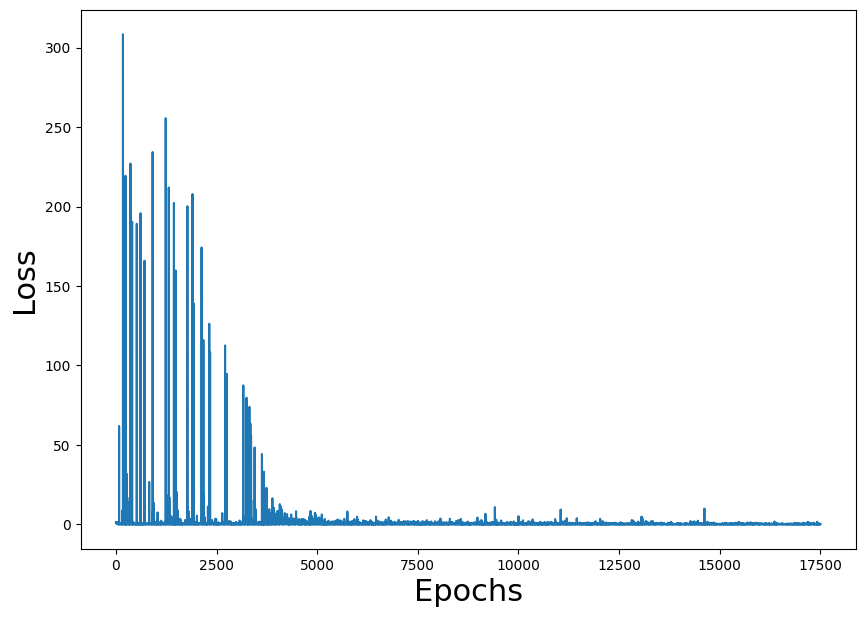

In [9]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [10]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    status = 1
    while(status == 1): 
        qval = model(state) # 예측
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) # 가장 가치가 높은 액션 선택
        action = action_set[action_] 
        if display:
            print('Move #: %s; Taking action: %s' % (i, action)) 
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 # 움직임 이후의 다음 state불러오기
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1: # 게임의 종료
            if reward > 0:
                status = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                status = 0
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if status == 2 else False # 처음보는 문법인데.. if를 기준으로 True면 왼쪽실행 False면 오른쪽실행한다 else는 필수인듯
    return win

In [11]:
test_model(model)

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

궁금증1. 같은 게임에서 배치가 바뀌어도 학습없이 잘 할수있을까?

나의 예상: 잘할수있을것같다

In [12]:
test_model(model,mode='random')

Initial State:
[[' ' '-' ' ' ' ']
 [' ' ' ' ' ' 'W']
 ['P' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 0; Taking action: u
[[' ' '-' ' ' ' ']
 ['P' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 1; Taking action: u
[['P' '-' ' ' ' ']
 [' ' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 2; Taking action: d
[[' ' '-' ' ' ' ']
 ['P' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 3; Taking action: u
[['P' '-' ' ' ' ']
 [' ' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 4; Taking action: d
[[' ' '-' ' ' ' ']
 ['P' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['P' '-' ' ' ' ']
 [' ' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 6; Taking action: d
[[' ' '-' ' ' ' ']
 ['P' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 7; Taking action: u
[['P' '-' ' ' ' ']
 [' ' ' ' ' ' 'W']
 [' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']]
Move #: 8; Taking action: d
[[' ' '-' ' ' ' ']
 ['P' ' ' ' ' 'W']
 [

False

잘하지못했다 한번도 학습되어본적이 없는 input이 들어와서 전혀 제대로된 예측을 하고있지않는것같다

mode='random'으로 설정하고 학습을 진행하더라도 loss가 수렴하지않아 의미있는 학습결과를 보여주지 못한다고 했다(그렇군...)
해당 학습 모델은 플레이를 말그대로 "암기"했을뿐 전혀 일반화 하지못하고 있는뜻과 같다
다행인건 딥마인드도 이런문제를 겪었고 그들은 해결책을 찾았다는것이다

경험재현

In [23]:
game = Gridworld(size=4, mode='random')
# state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
# state1 = torch.from_numpy(state1_).float()

In [27]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 0]]], dtype=uint8)

In [21]:
from collections import deque
epochs = 5000 # 에폭수 = 게임수
losses = [] # 손실값이 저장될 배열
mem_size = 1000 # 경험재현 목록의 길이제한
batch_size = 200 # 배치사이즈
replay = deque(maxlen=mem_size) # 덱 자료구조의 활용으로 최근 최대 1000개의 경험만 보관하게 된다
max_moves = 50 # 한게임에 50턴을 초과할경우 패배한다
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random') # random(지형지물, 플레이어 위치 랜덤생성)
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0 # (4, 4, 4) -> (1,64)  
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #E
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #F
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #G
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size: #I
            minibatch = random.sample(replay, batch_size) #J
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #K
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #L
            with torch.no_grad():
                Q2 = model(state2_batch) #M
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #N
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #O
            status = 0
            mov = 0
losses = np.array(losses)

리플레이 개수751
29 0.16432075202465057


In [22]:
print(f'리플레이 개수{len(replay)}')

리플레이 개수751
